In [1]:
import random
import math
from matplotlib import pyplot as plt
import numpy as np

In [2]:
N = 10
RANDOM_WALK_END = 6
NUM_RUNS = 100
NUM_EPISODES = 800
PROB_OF_RIGHT = 0.6

In [3]:
def calculate_state_values(end, prob_of_right):
    num_states = 2 * end + 1
    coeff_matrix = []
    for i in range(num_states):
        if i == 0:
            row = [1] + [0] * (num_states - 1) + [0]
        elif i < num_states - 1:
            row = [0] * (i - 1) + [1 - prob_of_right, -1, prob_of_right] + [0] * (num_states - 3 - (i - 1)) + [0]
        else:
            row = [0] * (num_states - 1) + [1] + [1]
        coeff_matrix.append(np.array(row))
    # Gauss elimination
    for row_id in range(1, num_states - 1):
        row = coeff_matrix[row_id]
        prev_row = coeff_matrix[row_id - 1]
        mult = -row[row_id - 1]/prev_row[row_id - 1]
        coeff_matrix[row_id] += mult * prev_row 
    for row_id in range(num_states - 2, 0, -1):
        row = coeff_matrix[row_id]
        row_below = coeff_matrix[row_id + 1]
        mult = -row[row_id + 1]/row_below[row_id + 1]
        coeff_matrix[row_id] += mult * row_below
    return [row[-1]/row[i] for i, row in enumerate(coeff_matrix)][1:-1]

In [4]:
class RandomWalk:
    def __init__(self, end):
        self.end = end
        self.current = 0
        
    def reset(self):
        self.current = 0

    def take_action(self):
        right = random.randint(0, 1)
        if right:
            action = 1
            self.current += 1
        else:
            action = -1
            self.current -= 1
        is_terminal = False
        r = 0
        if abs(self.current) == abs(self.end):
            is_terminal = True
            if self.current > 0:
                r = 1
        return is_terminal, action, self.current, r

In [5]:
class Estimator:
    def __init__(self, random_walk, n, gamma, prob_of_right):
        self.end = random_walk.end
        self.num_states = random_walk.end * 2 - 1
        self.V = [0.5 for _ in range(self.num_states)]
        self.n = n
        self.gamma = gamma
        self.prob_of_right = prob_of_right
        self.target_values = calculate_state_values(random_walk.end, prob_of_right)
    
    def get_prob(self, action):
        if action == 1:
            return self.prob_of_right
        else:
            return 1 - self.prob_of_right
    
    def get_V_idx(self, state):
        return state + self.end - 1
    
    def getRMSE(self):
        rmse = math.sqrt(
            sum(((x - y)**2 for (x, y) in zip(self.V, self.target_values)))/self.num_states)
        return rmse

In [6]:
class SimpleEstimator(Estimator):
    def __init__(self, n, alpha, random_walk, gamma, prob_of_right):
        self.alpha = alpha
        self.random_walk = random_walk
        super().__init__(random_walk, n, gamma, prob_of_right)
        
    def learn(self, num_episodes):
        mod = self.n + 1
        rmses = []
        for _ in range(num_episodes):
            self.random_walk.reset()
            R = [0 for _ in range(mod)]
            states = [0 for _ in range(mod)]
            actions = [0 for _ in range(mod)]
            T = float('inf')
            t = 0
            to_update = 0
            while to_update < T - 1:
                if t < T:
                    terminal, action, state, r = self.random_walk.take_action()
                    prev_idx = t % mod
                    actions[prev_idx] = action
                    idx = (t + 1) % mod
                    R[idx] = r
                    states[idx] = state
                    if terminal:
                        T = t + 1
                to_update = t - self.n + 1
                if to_update > 0:
                    to_update_idx = to_update % mod
                    use_steps_until = min(to_update + self.n, T) + 1
                    G = 0
                    sampling_correction = 1
                    for i in range(to_update + 1, use_steps_until):
                        prev_idx = (i - 1) % mod
                        a = actions[prev_idx]
                        sampling_correction *= self.get_prob(a)/0.5
                        next_idx = i % mod
                        next_r = R[next_idx]
                        G += self.gamma **(i - to_update - 1) * next_r
                    if to_update + self.n < T:
                        G += self.gamma ** self.n * self.V[self.get_V_idx(state)]
                    state_to_update = self.get_V_idx(states[to_update % mod])
                    self.V[state_to_update] += self.alpha * (sampling_correction * G - self.V[state_to_update])
                t += 1
            rmses.append(self.getRMSE())
        return rmses

In [7]:
class ControlVariateEstimator(Estimator):
    def __init__(self, n, alpha, random_walk, gamma, prob_of_right):
        self.alpha = alpha
        self.random_walk = random_walk
        super().__init__(random_walk, n, gamma, prob_of_right)
        
    def learn(self, num_episodes):
        mod = self.n + 1
        rmses = []
        for _ in range(num_episodes):
            self.random_walk.reset()
            R = [0 for _ in range(mod)]
            states = [0 for _ in range(mod)]
            actions = [0 for _ in range(mod)]
            T = float('inf')
            t = 0
            to_update = 0
            while to_update < T - 1:
                if t < T:
                    terminal, action, state, r = self.random_walk.take_action()
                    prev_idx = t % mod
                    actions[prev_idx] = action
                    idx = (t + 1) % mod
                    R[idx] = r
                    states[idx] = state
                    if terminal:
                        T = t + 1
                to_update = t - self.n + 1
                if to_update > 0:
                    to_update_idx = to_update % mod
                    use_steps_until = min(to_update + self.n, T)
                    G = 0
                    sampling_correction = 1
                    for i in range(to_update, use_steps_until):
                        idx = i % mod
                        a = actions[idx]
                        sampling_i= self.get_prob(a)/0.5
                        state_i = self.get_V_idx(states[idx])
                        G += (self.gamma ** (i - to_update)
                              * sampling_correction
                              * (1 - sampling_i) * self.V[state_i])
                        next_idx = (i + 1) % mod
                        next_r = R[next_idx]
                        sampling_correction *= sampling_i
                        G += self.gamma **(i - to_update) * sampling_correction * next_r
                    if to_update + self.n < T:
                        idx = (to_update + self.n) % mod
                        a = actions[idx]
                        state_i = self.get_V_idx(states[idx])
                        sampling_correction *= self.get_prob(a)/0.5
                        G += self.gamma ** self.n * sampling_correction * self.V[self.get_V_idx(state)]
                    state_to_update = self.get_V_idx(states[to_update % mod])
                    self.V[state_to_update] += self.alpha * (G - self.V[state_to_update])
                t += 1
            rmses.append(self.getRMSE())
        return rmses

In [8]:
def learn(cls, alpha):
    sum_rmses = [0 for _ in range(NUM_EPISODES)]
    for _ in range(NUM_RUNS):
        est = cls(N, alpha, RandomWalk(RANDOM_WALK_END), 1, PROB_OF_RIGHT)
        rmses = est.learn(NUM_EPISODES)
        sum_rmses = map(sum, zip(sum_rmses, rmses))
    return [rmse/NUM_RUNS for rmse in sum_rmses]

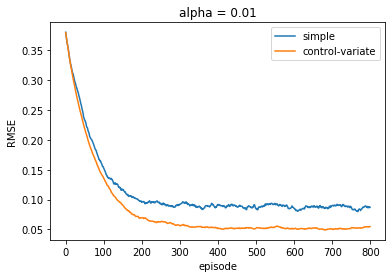

In [9]:
a = 0.01
control_variate_rmses = learn(ControlVariateEstimator, a)
simple_rmses = learn(SimpleEstimator, a)
plt.plot(simple_rmses)
plt.plot(control_variate_rmses)
plt.xlabel('episode')
plt.ylabel('RMSE')
plt.title(f'alpha = {a}')
plt.legend(['simple', 'control-variate'], loc='upper right')
plt.savefig(f'{a}.png')

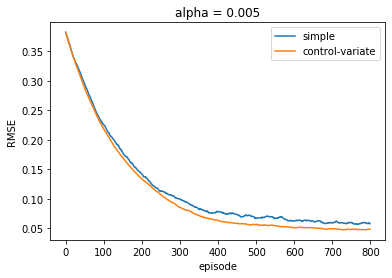

In [10]:
a = 0.005
control_variate_rmses = learn(ControlVariateEstimator, a)
simple_rmses = learn(SimpleEstimator, a)
plt.plot(simple_rmses)
plt.plot(control_variate_rmses)
plt.xlabel('episode')
plt.ylabel('RMSE')
plt.title(f'alpha = {a}')
plt.legend(['simple', 'control-variate'], loc='upper right')
plt.savefig(f'{a}.png')

In [16]:
calculate_state_values(RANDOM_WALK_END, PROB_OF_RIGHT)

[0.3359224037394875,
 0.5598706728991458,
 0.7091695190055846,
 0.8087020830765439,
 0.875057125790517,
 0.9192938209331655,
 0.9487849510282643,
 0.9684457044249969,
 0.9815528733561518,
 0.9902909859769219,
 0.9961163943907687]